In [67]:
import sys
sys.path.append('../utils/')

from trading_days import TradingDay
from datetime import datetime, timedelta
from itertools import chain

import seaborn as sns
from sqlalchemy import create_engine
import datetime
import pandas as pd
from pygments import highlight
from pygments.lexers.sql import SqlLexer
from pygments.formatters import HtmlFormatter, LatexFormatter
from IPython import display
import matplotlib.pyplot as plt
from __future__ import division
import numpy as np
from datetime import date
%matplotlib inline

from query import query_dataframe_f, pprint_query, nbprint_and_query, query_dataframe
use_latex = False

In [2]:
def ATM(Ticker,Date_Start,Date_End):
    '''
        The query selects all minimum strike differences for each 
        date in the date range considered for the selected ticker 
        with (-10,+10) buffer around start and end date
    '''
    sql_raw = open('ATM.sql', 'r').read()
    sql_format = sql_raw.format(
            ticker = Ticker, 
            date_start = Date_Start, # yyyy-MM-dd
            date_end = Date_End, # yyyy-MM-dd
        )
    data = query_dataframe(sql_format) 
    return data

def Expirations(Ticker,Date_Start,Date_End):
    '''
        The query selects all expirations for options in 
        the date range considered for the selected ticker
    '''
    sql_raw = open('Exp.sql', 'r').read()
    sql_format = sql_raw.format(
            ticker = Ticker, 
            date_start = Date_Start, # yyyy-MM-dd
            date_end = Date_End, # yyyy-MM-dd
        )
    data = query_dataframe(sql_format).astype(pd.datetime) 
    # Create a column with day of the week id
    data['WeekDay'] = data.Expiration.dt.dayofweek
    return data

# Safer to work with Security IDs in some cases
def ATM_ID(ID,Date_Start,Date_End):
    '''
        The query selects all minimum strike differences for each 
        date in the date range considered for the selected ID 
        with (-10,+10) buffer around start and end date
    '''
    sql_raw = open('ATM_ID.sql', 'r').read()
    sql_format = sql_raw.format(
            sec_id = ID, 
            date_start = Date_Start, # yyyy-MM-dd
            date_end = Date_End, # yyyy-MM-dd
        )
    data = query_dataframe(sql_format) 
    return data

def Expirations_ID(ID,Date_Start,Date_End):
    '''
        The query selects all expirations for options in 
        the date range considered for the selected ID
    '''
    sql_raw = open('Exp_ID.sql', 'r').read()
    sql_format = sql_raw.format(
            sec_id = ID, 
            date_start = Date_Start, # yyyy-MM-dd
            date_end = Date_End, # yyyy-MM-dd
        )
    data = query_dataframe(sql_format).astype(pd.datetime) 
    # Create a column with day of the week id
    if not data.empty:
        data['WeekDay'] = data.Expiration.dt.dayofweek
    return data

In [3]:
def trading_window(date,n):
    '''
        Selecting a (-n,+n) interval of trading days aroun date
    '''
    starting_date = -TradingDay(n) + date
    return [starting_date + TradingDay(i)
            for i in range(n*2+1)]

In [49]:
def pinning_data(ticker_id,Date_Start,Date_End,delta_t,identifier):
    '''
    The function returns a data frame with minimum strike difference for 
    -delta_t,+delta_t days around each expiration date considered in the date range
    given a selected Ticker
    '''
    strike_diff = []
    dates = []
    # Getting ATM series and expirations
    if identifier=='ID':
        atm = ATM_ID(ticker_id,Date_Start,Date_End)
        exp_dates = Expirations_ID(ticker_id,Date_Start,Date_End)
    else:
        atm = ATM(ticker_id,Date_Start,Date_End)
        exp_dates = Expirations(ticker_id,Date_Start,Date_End)
    if exp_dates.empty:
        return []
    for exp in exp_dates.Expiration.values:
        dates.append(exp)
        # Selecting the right expiration date in case it was a Saturday
        if exp_dates.WeekDay[exp_dates.Expiration==exp].values[0]==5:
            real_exp = exp-TradingDay(1)
        else:
            real_exp = exp
        # Creaiting a date window with the dates of interest
        exp_window = trading_window(real_exp,delta_t)
        # Creating a data frame for .csv output
        df = atm[atm.Date.isin(exp_window)].drop_duplicates('Date')
        df.Date = df.Date.astype(pd.datetime)
        df['Ticker/ID'] = ticker_id
        df['Real Expiration'] = real_exp
        df['Ivy Expiration'] = exp
        if identifier=='ID':
            df.to_csv('ID_data.csv', mode='a',header=False,index=False)
        else:
            df.to_csv(ticker_id+'.csv', mode='a',header=False,index=False)
        # Dealing with missing data from some trading dates
        if len(df[df.Date.isin(exp_window)])!=11:
            exp_df = pd.DataFrame(np.array([exp_window]).T,
                            columns=['Date']).astype(pd.datetime)
            exp_df = exp_df.merge(df,how='left',on='Date',suffixes=('', ''))
            strike_diff.append(exp_df.strike_diff.values) 
        else:
            strike_diff.append(df.strike_diff.values)
    # Defining the day expiration window        
    DeltaDays = [str(i) for i in range(-delta_t,delta_t+1)]
    # Returning strike differences and expiration dates
    res = pd.DataFrame(np.array(strike_diff), index=dates, columns=DeltaDays)
    if identifier=='ID':
        res.to_csv('ID_pin_data.csv', mode='a',header=False,index=False)
    else:
        res.to_csv(ticker_id+'_pin_data.csv')
    return res

In [50]:
# Plotting pinning probabilities given a dataframe returned from pinning_data()
def pinning_hist(p_data,cut_off,ticker):
    '''
        Histogram plot of the pinning probabilities in the day range
        pre-post expiration. The probability percentage count takes into
        account also the missing data around some strikes related 
        to special circumstances in which the stock was not traded 
        even though the day was a normal trading day
    '''
    # Counting the number of missing values for each day
    n_counts = (p_data.isnull().sum()).values
    # Pinning probability for each day
    p_prob = np.sum(1*(p_data.values<cut_off),axis=0)/(p_data.shape[0]-n_counts)
    plt.figure(figsize=((15,6)))
    plt.bar(range(-5,5+1),p_prob, align='center')
    plt.title(ticker+' pinning probability')
    plt.xlabel('DeltaExpiration')
    p_range = np.max(p_prob)-np.min(p_prob)
    plt.ylim((np.min(p_prob)-p_range,np.max(p_prob)+p_range))
    plt.show()

# Q1 
**Consider INTC, KO, and then all optionable stocks in IVY (not indices, see the index flag on the security table). a) For the period of 1/1/1996 to 1/8/2013 for INTC and KO, reproduce the PPN bar graph for T-5 to T+5 trading days about expirations using a cut-off of USD 0.15 to define pinning. b) Do the same for all optionable stocks for the period 1/1/2012 to 1/1/2013. How reasonable are the statistics for these abbreviated sets (especially single stocks)?**

## a)

In [54]:
%%time
# Otbtaining historical values for KO
start_date = '1996-01-01'
end_date = '2013-08-01'

KO = pinning_data('KO',start_date,end_date,5,'')

CPU times: user 2min 47s, sys: 184 ms, total: 2min 47s
Wall time: 3min 11s


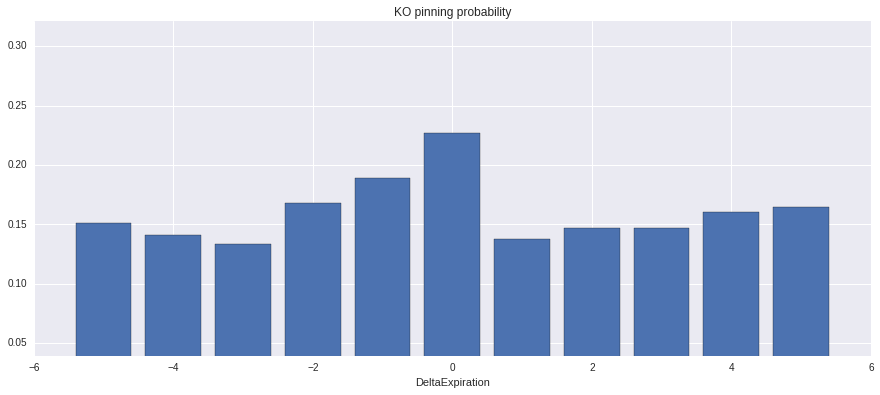

In [55]:
pinning_hist(KO,0.15,'KO')

In [56]:
%%time 
INTC = pinning_data('INTC',start_date,end_date,5,'')

CPU times: user 3min 2s, sys: 292 ms, total: 3min 3s
Wall time: 3min 20s


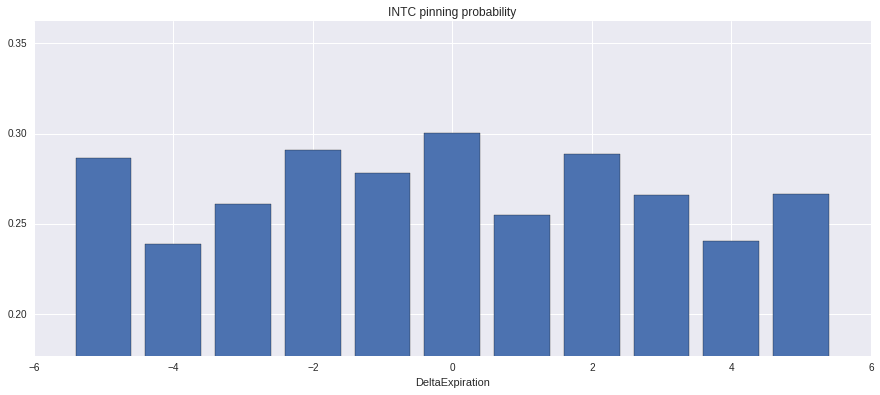

In [57]:
pinning_hist(INTC,0.15,'INTC')

The histograms por pinning probabilities in part a) clearly show that KO and INTC have different behaviour. In fact, KO has a high pinning probability at expiration compared to the other days in the DeltaExpiration window. It can be seen that the pinning probability is increasing starting from 3 days before expirations and collapsing on the day after. The pinning probability is then rising when going towards the boundaries of the DeltaExpiration range. This can be due to the fact that starting from July 2011 KO options have expirations every week and $-5,+5$ days are in these cases expiration dates as well. For INTC we do observe that the pinning probability has a maximum at expiration date, but this maximum does not seem to be significantly higher than the pinning probabilities on the other days in the DeltaExpiration interval. On the long period considered for KO and INTC, the minimum strike price tick has changed in value (e.g. USD 5,2.5,1,...), especially for INTC. This fact can have some direct impact on the calculations of pinning probabilities. At a fixed cut-off (USD 0.15 in our analysis) periods with larger strike price tick will have less weight on the overall count as the pinning probability will be lower. Morover, if the strike price tick is changing within the DeltaExpiration window, as it should be when we roll from one expiration to the other, then our results can be not so accurate. The different results for INTC and KO can also be due to the different levels of implied volatility of the two stocks. KO shows historically a much lower implied volatility than INTC and thus pinning behaviour at expiration is much more likely. To investigate the impact of strike price tick change on INTC pinning probability graphs we will look at two different periods where strike price ticks where different (cut-off fixed at USD 0.15).

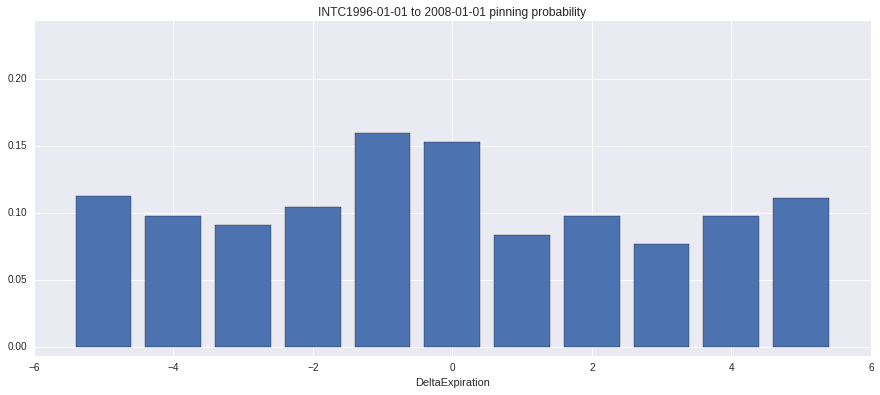

CPU times: user 1min 28s, sys: 52 ms, total: 1min 28s
Wall time: 1min 48s


In [70]:
%%time
start_date = '1996-01-01'
end_date = '2008-01-01'
INTC = pinning_data('INTC',start_date,end_date,5,'')
pinning_hist(INTC,0.15,'INTC '+start_date+' to '+end_date)

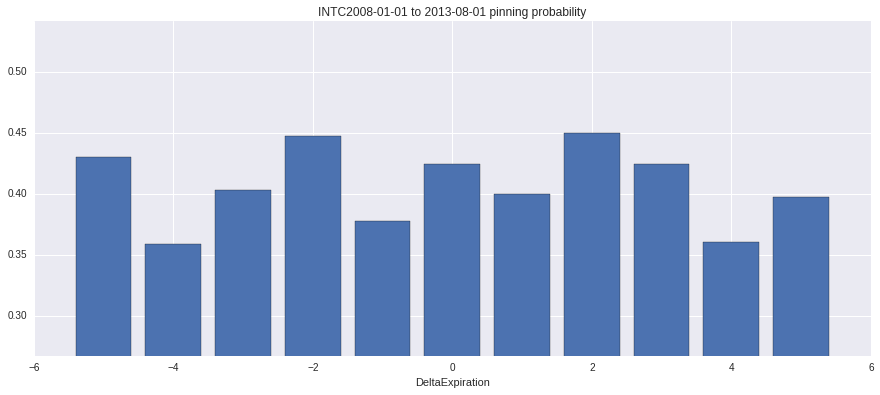

CPU times: user 1min 39s, sys: 60 ms, total: 1min 39s
Wall time: 1min 55s


In [71]:
%%time
start_date = '2008-01-01'
end_date = '2013-08-01'
INTC = pinning_data('INTC',start_date,end_date,5,'')
pinning_hist(INTC,0.15,'INTC '+start_date+' to '+end_date)

As we can see from the above histograms, for the period from 1996 to 2008, pinning probability on expiration and day before expiration is significantly higher than the other days in the DeltaExpiration interval. This is not the case for the period from 2008 to 2013 where other factors like implied volatility, volume and open interest may have influenced the probability of pinning at expiration. 

## b)

In [6]:
# Select all stocks securityIDs with options trading between 2012-01-01 and 2013-01-01
start_date = '2012-01-01'
end_date = '2013-01-01'

In [ ]:
# Obtaining all of the optionable stocks IDs for the date range considered
query = ''' SELECT Distinct(op.SecurityID)
            FROM XFDATA.dbo.SECURITY s INNER JOIN XFDATA.dbo.OPTION_PRICE_VIEW op
            on s.SecurityID=op.SecurityID
            WHERE Date BETWEEN '%s' AND '%s' 
            AND s.IssueType='0'  ''' % (start_date,end_date)

opt_stocks_ID = query_dataframe(query)
opt_stocks_ID.to_csv('IDS.csv')

In [7]:
# Calling the pinning_data() function on all of IDs
IDs = pd.read_csv('IDS.csv').SecurityID.values
all_optionable = dict((id,pinning_data(id,start_date,end_date,5,'ID')) for id in IDs)

In [14]:
# Reading pinning data from csv
pinning = pd.read_csv('ID_pin_data.csv')

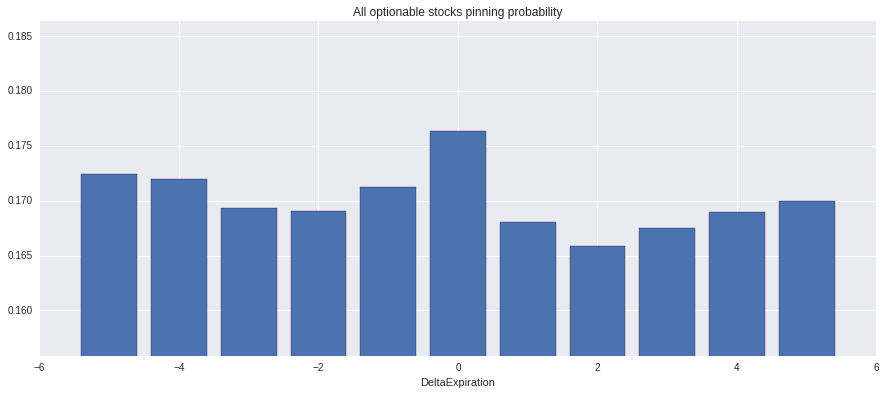

In [27]:
pinning_hist(pinning,0.15,'All optionable stocks')

The histogram for pinning probabilities for all optionable stocks show some evidence of pinning. The pinning probability distribution has a maximum on expiration date.  

# Q4
**ETFs and Indices. Previous classes showed that indices DID NOT PIN. Now there are
many ETFs that may be traded in lieu of the individual names. Pick 3 unrelated ETFs
and see how often they pin in a three year period of your choosing.**

In [58]:
# Pinning graphs for 'GLD', 'USO', 'COW' ETSs
start_date = '2010-01-01'
end_date = '2013-01-01'

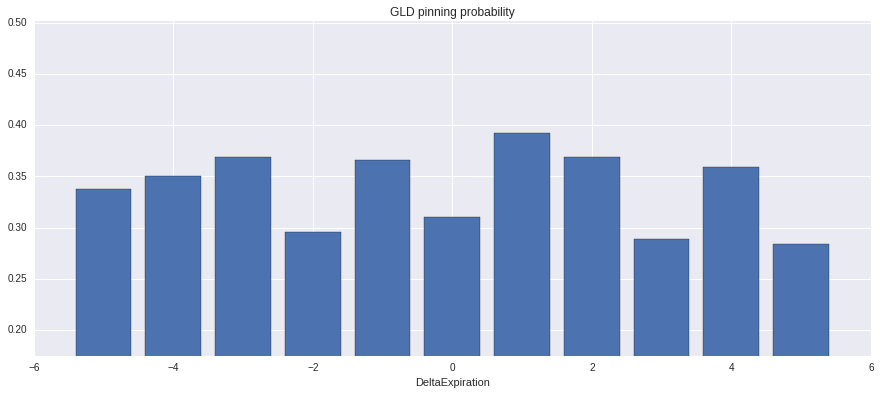

CPU times: user 1min 13s, sys: 56 ms, total: 1min 13s
Wall time: 5min 40s


In [62]:
%%time
GLD = pinning_data('GLD',start_date,end_date,5,'')
pinning_hist(GLD,0.15,'GLD')

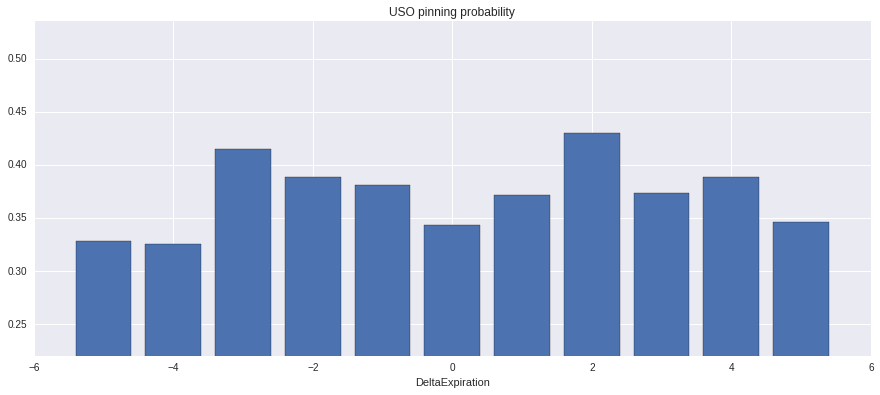

CPU times: user 1min 10s, sys: 52 ms, total: 1min 10s
Wall time: 1min 26s


In [64]:
%%time
USO = pinning_data('USO',start_date,end_date,5,'')
pinning_hist(USO,0.15,'USO')

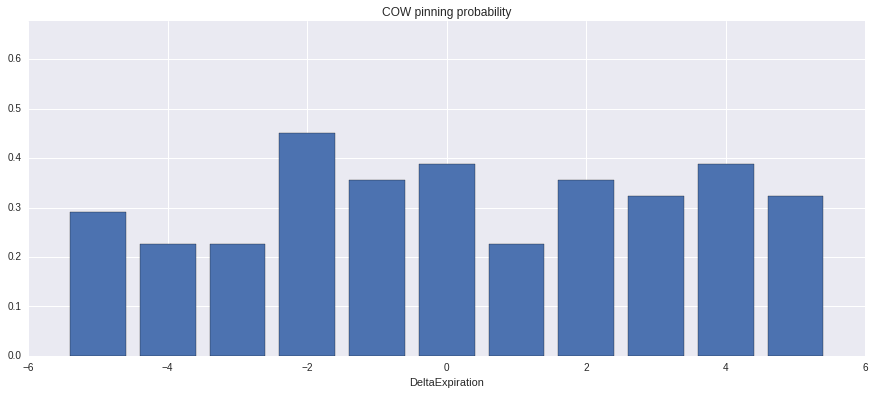

CPU times: user 17.8 s, sys: 20 ms, total: 17.8 s
Wall time: 25.4 s


In [65]:
%%time
COW = pinning_data('COW',start_date,end_date,5,'')
pinning_hist(COW,0.15,'COW')

As we can see from the above histograms, none of the ETFs of interest showed pinning probability at expiration exceeding signicantly the pinning probabilities in the considered window. 